# Ejemplo 1


## **1. Presentación del algoritmo**



La idea con el algoritmo PPO es mejorar la estabilidad del entrenamiento de la política al limitar el cambio en la política en cada época de entrenamiento: evita tener actualizaciones de políticas demasiado grandes.

Por dos razones:

- Sabemos empíricamente que las actualizaciones de políticas más pequeñas durante la capacitación son más probables que converja a una solucion óptima.

- Un paso demasiado grande en una actualización de política puede resultar en una caída "del acantilado"(obtener una mala política) y tener mucho tiempo o incluso ninguna posibilidad de recuperarse.


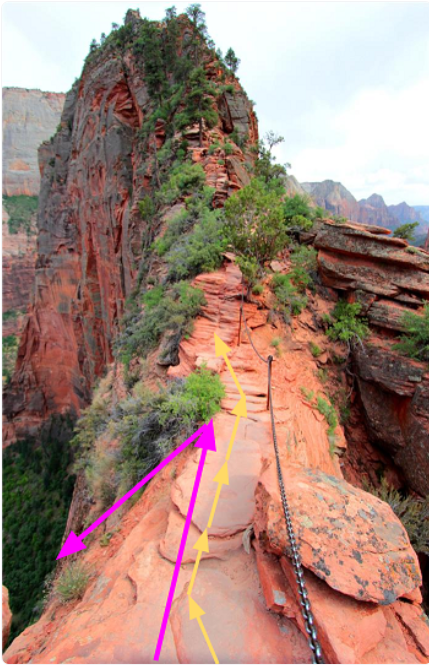

*Tomar actualizaciones políticas más pequeñas mejora la estabilidad de la capacitación.*

Policy Objective Function

$$L^{PG}(Θ) = E_t[log\pi_Θ(a_t│s_t)*A_t]$$

- $log\pi_Θ(a_t│s_t)$: Probabilidad de realizar esa acción en ese estado.
- $A_t$: Ventaja de A>0, esta acción es mejor que la otra acción posible en ese estado.

La idea es que al dar un paso de gradiente en esta función(equivalente a tomar un descenso de gradiente del negativo de esta función), lo haríamos empuje a nuestro agente a tomar medidas que conduzcan a mayores recompensas y eviten acciones dañinas.

Aquí con PPO, la idea es limitar nuestra actualización de políticas con una nueva función objetiva llamada **Función objetiva sustituta recortada** eso limitará el cambio de política en un rango pequeño usando un clip.

Esta nueva función está diseñada para evitar actualizaciones destructivas de pesos grandes:

$$L^{CLIP}(\theta)=\widehat{\mathbb{E}}_t[min(r_t(\theta)\widehat{A}_t,clip(r_t(\theta),1-ϵ,1+ϵ)\widehat{A}_t)]$$

Estudiamos cada parte para ver el funcionamiento:

The ratio function: $r_t(θ)=\frac{π_\theta(a_t│s_t)}{π_{θ_old}(a_t│s_t)}$

$r_t(θ)$: denota la relación de probabilidad entre la política actual y la antigua:

- Si $r_t(\theta)>1$, la acción $a_t$ en estado $s_t$ es más probable en la política actual que en la política anterior.
- Si $r_t(\theta)$ está entre 0 y 1, la acción es menos probable para la política actual que para la anterior.

Entonces esta relación de probabilidad es una manera fácil de estimar la divergencia entre la política antigua y la actual.

The unclipped part: $r_t(θ)A_t$, esta relación puede reemplazar la probabilidad de registro que usamos en la función de objetivo de política. Esto nos da la parte izquierda de la nueva función objetiva: multiplicar la relación por la ventaja.

$$L^{CPI}(\theta)=\widehat{\mathbb{E}}[\frac{π_\theta(a_t│s_t)}{π_{θ_old}(a_t│s_t)}]=\widehat{\mathbb{E}}[r_t(θ)\widehat{A}_t]$$


Sin embargo, sin restricciones, si la acción tomada es mucho más probable en nuestra política actual que en la nuestra anterior, esto llevaría a un importante paso de gradiente de políticas y, por tanto, una actualización excesiva de la política.

The clipped objective: $clip(r_t(\theta),1-ϵ,1+ϵ)$, debemos restringir esta función objetiva penalizando los cambios que conducen a una realación de 1.

Al recortar la proporción, nos aseguramos de no tener una actualización de política demasiado grande porque la política no puede ser muy diferente de la anterior.

Esta parte recortada es una versión en la que rt(theta) se corta entre $[1-ε. 1 + ε]$.

Con la función Objetivo sustituto recortado, tenemos dos índices de probabilidad, uno no recortado y otro recortado en un rango (entre $[1-ε, 1 + ε]$, $ε$ es un hiperparámetro que nos ayuda a definir este rango de clip $0.2.$).

Luego, tomamos el mínimo del objetivo recortado y no recortado,entonces el objetivo final es un límite inferior(límite pesimista) del objetivo no recortado. Toma el mínimo de los medios objetivos recortados y no recortados seleccionaremos el objetivo recortado o no recortado en función de la relación y la situación de ventaja.

Esto concluye las discusiones de este capítulo sobre las restricciones al gradiente de política. Comenzamos con el objetivo de gradiente de política $J(\theta)=$ utilizado en REINFORCE y Actor-Critic. Luego introdujimos un objetivo sustituto $J^{CPI}(\theta)$ con la promesa de mejoras monótonas, que se mantiene si restringimos la diferencia entre políticas sucesivas. PPO presentó dos formas de restringir el objetivo sustituto: usar una penalización KL o una heurística de recorte, lo que nos da $J^{KLPEN}$ y $J^{CLIP}$, respectivamente. Reunamos todos estos objetivos de gradiente de políticas y comparémoslos.


- objetivo original: $J(θ)=\mathbb{E}_t[A_t^{πθ} logπ_θ(a_t | s_t)]$
- objetivo sustituto: $J^{CPI}(\theta)=\mathbb{E}_t[r_t(\theta)A_t^{\pi_{θ_old}}]$
- objetivo sustituto restringido: $J^{cpi}(\theta) subject to \mathbb{E}_t[KL(π_θ || π_{θ_old})] \leq δ$
- PPO con penalización KL: $J^{KLPEN}(θ)=\mathbb{E}_t[r_t(θ)A_t^{π_{θ_old}}-βKL(π_θ || π_{θ_old})]$
- PPO con recorte: $J^{CLIP}(\theta)=\mathbb{E}_t[min(r_t(\theta)A_t^{π_{θ_old}},clip(r_t(\theta),1-ϵ,1+ϵ)A_t^{π_{θ_old}})]$

## **2. Implementación de PPO (Proximal Policy Optimization)**

En esta sección nos centraremos exclusivamente en la implementación de un agente con PPO, utilizando TensorFlow. Así mismo, también generaremos unos gráficos donde nos mostrará las recompensas y pérdidas obtenidas por el agente. Finalmente, obtendremos un gif en el cual podremos visualizar cómo el agente entrenado, interactúa en el entorno de CartPole-v0.

Nota: Los resultados serán parciales, para observar los resultados definitivos, ver la sección 3 (Sección 3 Validación de Resultados).

### *2.1 Importación de librerías e instalación de open ai gym*
En esta sección importaremos las librerías necesarias para utilizar tensorflow, open ai gym y el generado de un gif que nos permitirá ver como actúa el agente en un entorno.

In [ ]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm
from PIL import Image as pil_image
from IPython.display import Image as mostrar_imagen
import warnings
warnings.filterwarnings("ignore")

random.seed(202)
tf.random.set_seed(202)

### *2.2 Creación del algoritmo PPO (Proximal Policy Optimization).*
En esta sección desarrollaremos la creación del Actor Crítico para la aplicación del algoritmo PPO. El juego elegido a resolver será "CartPole-v0".

Aquí instanciamos el juego *CartPole-v0* para obtener lo siguiente:

- action_size: Son las acciones que puede hacer el agente. En este caso, el agente solo puede ir de izquierda a derecha.
- observation_space: Es la cantidad de datos de entrada para una red neuronal.

In [ ]:
juego = "CartPole-v0"
env = gym.make(juego)

obs_size = env.observation_space.shape[0]
action_size = env.action_space.n

Definimos una función para crear a un Actor y un Crítico.

In [ ]:
def construir_actor(obs_size, action_size):
    """
    Definimos esta función para crear el actor con sus
    respectivas capas ocultas y una función de
    activación ReLu
    """
    entrada = tf.keras.layers.Input((obs_size,))

    # Capas ocultas
    # Iniciamos las capas ocultas con una función de activación ReLu
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.Orthogonal)(entrada)
    x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.Orthogonal)(x)

    politica = tf.keras.layers.Dense(action_size, activation='softmax')(x)

    actor = tf.keras.models.Model(entrada, politica)

    return actor

In [ ]:
def construir_critico(obs_size):
    """
    Definimos esta función para crear el crítico con sus
    respectivas capas ocultas y una función de
    activación ReLu
    """
    entrada = tf.keras.layers.Input((obs_size,))

    # Capas ocultas
    # Iniciamos las capas ocultas con una función de activación ReLu
    x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.Orthogonal)(entrada)
    x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.Orthogonal)(x)

    valor = tf.keras.layers.Dense(1)(x)

    critico = tf.keras.models.Model(entrada, valor)

    return critico

Creamos la clase PPO que implementará el algoritmo presentado en la PC 5 en la función **entrenar**.

In [ ]:
class PPO:
    def __init__(self, lr_actor, lr_critic, epocas, epsilon, minibatch_size, entropia):
        """
        Al crear un objeto PPO, asignaremos los hiperparámetros presentados
        en el algoritmo, como:
            - learning rate actor
            - learning rate critic
            - epocas
            - epsilon
            - minibatch
            - entropia
        """
        self.policy_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_actor, beta_1=0.9)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_critic, beta_1=0.9)
        self.epocas = epocas
        self.epsilon = epsilon
        self.minibatch_size = minibatch_size
        self.entropia = entropia

        self.actor = construir_actor(obs_size, action_size)
        self.critico = construir_critico(obs_size)

    def accion(self, estado):
        """
        Te retorna la acción que realizará el agente,
        de acuerdo al estado que se le ingrese.
        """
        politica = self.actor(np.array([estado]))
        accion = random.choices([i for i in range(action_size)], weights=politica[0], k=1)
        return accion, politica[0]

    def minibatch(self, info):
        """
        Esta función sirve para dividir los datos en minibatches
        lo que permite ejecutar de forma más rápida la decisión
        del agente.
        """
        returns, ventajas, estados, acciones, probs = info
        returns_batch, adv_batch, estados_batch, acciones_batch, probs_batch = [], [], [], [], []
        idxs = np.arange(len(returns))
        np.random.shuffle(idxs)
        for k in idxs:
            returns_batch.append(returns[k])
            estados_batch.append(estados[k])
            acciones_batch.append(acciones[k])
            probs_batch.append(probs[k])
            adv_batch.append(ventajas[k])
            if len(estados_batch) == self.minibatch_size:
                yield np.array(returns_batch), np.array(adv_batch), np.array(estados_batch), np.array(acciones_batch), np.array(probs_batch)
                returns_batch, adv_batch, estados_batch, acciones_batch, probs_batch = [], [], [], [], []

    def generar_datos(self, nro_pasos, env):
        """
        Se generan los datos necesarios, para poder entrenar
        a nuestro agente.
        """
        recompensas = np.empty((nro_pasos, ), dtype=np.float32)
        dones = np.empty((nro_pasos, ), dtype=bool)
        estados = np.empty((nro_pasos, obs_size), dtype=np.float32)
        acciones = np.empty((nro_pasos, ), dtype=np.int32)
        probs = np.empty((nro_pasos, action_size), dtype=np.float32)
        values = np.empty((nro_pasos + 1, ), dtype=np.float32)

        estado = env.reset()

        for i in tqdm(range(nro_pasos)):
            accion, politica = self.accion(estado)
            value = self.critico(np.array([estado]))[0]
            siguiente_estado, recompensa, done, _ = env.step(accion[0])
            estados[i] = estado
            probs[i] = politica
            dones[i] = done
            values[i] = value
            acciones[i] = accion[0]
            recompensas[i] = recompensa
            estado = siguiente_estado
            if done:
                estado = env.reset()
        values[nro_pasos] = self.critico(np.array([estado]))[0]

        returns = []
        gae = 0
        lmbda = 0.95
        gamma = 1

        for i in reversed(range(len(recompensas))):
            delta = recompensas[i] + gamma * values[i + 1] * (1 - dones[i]) - values[i]
            gae = delta + gamma * lmbda * gae * (1 - dones[i])
            returns.insert(0, gae + values[i])

        ventajas = np.array(returns) - values[:-1]
        ventajas = (ventajas - np.mean(ventajas)) / (np.std(ventajas) + 1e-8)
        return returns, ventajas, estados, acciones, probs

    def entrenar(self, info):
        """
        En esta función pone en ejecución el algoritmo PPO
        para el aprendizaje del agente.
        """
        politica_losses = []
        critico_losses = []

        # Realizamos la iteración de las épocas que se indica en el pseudocódigo
        for _ in range(self.epocas):

            # Realizamos la iteración de los minibatch
            for returns, ventajas, estados, acciones, old_probs in self.minibatch(info):
                old_logprobs_dist = np.log(old_probs + 1e-10)
                old_logprobs = tf.reduce_sum(old_logprobs_dist * tf.one_hot(acciones, depth=action_size), axis=-1)

                # Realizamos el cálculo de los pesos del actor y los ajustamos
                with tf.GradientTape() as tape1:
                    values = tf.reshape(self.critico(estados), (self.minibatch_size,))
                    critico_loss = 0.5 * tf.reduce_mean(tf.square(returns - values))

                grads = tape1.gradient(target=critico_loss, sources=self.critico.trainable_variables)
                self.critic_optimizer.apply_gradients(zip(grads, self.critico.trainable_variables))

                # Realizamos el cálculo de los pesos del crítico y los ajustamos
                with tf.GradientTape() as tape2:
                    politica = self.actor(estados)

                    # Realizamos esta conversión debido a un bug presentado
                    politica = tf.cast(politica, tf.float32)
                    acciones = tf.convert_to_tensor(acciones, tf.int32)

                    # Calculamos las probabilidades de las acciones del agente
                    logprobs = tf.reduce_sum(tf.math.log(politica) * tf.one_hot(acciones, depth=action_size), axis=-1)

                    # Calculamos la entropía
                    entropia = tf.reduce_mean(tf.math.negative(tf.math.multiply(politica, tf.math.log(politica))))

                    # Definimos los ratios, entre las antiguas probabilidades con
                    # las nuevas
                    ratios = tf.exp(logprobs - old_logprobs)
                    s1 = ratios * ventajas

                    # Aquí realizamos la acotación de la política, esto nos ayuda
                    # a que el algoritmo no se vaya muy lejos de su política anterior
                    s2 = tf.clip_by_value(ratios, 1 - self.epsilon, 1 + self.epsilon) * ventajas

                    politica_loss = -tf.reduce_mean(tf.minimum(s1, s2)) - self.entropia * entropia

                grads = tape2.gradient(target=politica_loss, sources=self.actor.trainable_variables)
                self.policy_optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))

                # Almacenamos todas las pérdidas para posteriormente
                # graficarlas con matplotlib
                politica_losses.append(politica_loss)
                critico_losses.append(critico_loss)
        return np.mean(politica_losses), np.mean(critico_losses)

    def testear(self, env, tests=100):
        """
        Esta función nos ayudará a testear el modelo entrenado.
        Básicamente prueba el modelo entrenado en un nuevo
        entorno de open ai gym y te retorna la recompensa obtenida
        dentro de dicho entorno.
        """
        returns = []
        for _ in range(tests):
            estado = env.reset()
            recompensa_acumulada = 0
            done = False
            while not done:
                politica = self.actor(np.array([estado]))
                accion = np.argmax(politica)
                estado, recompensa, done, _ = env.step(accion)
                recompensa_acumulada += recompensa
            returns.append(recompensa_acumulada)
        return np.mean(returns)

### *2.3 Instanciamos el entorno gym y el algoritmo PPO*
Instanciamos el entorno gym con el juego "CartPole-v0" y el algoritmo PPO, para posteriormente realizar el entrenamiento.

In [ ]:
"""
De acuerdo al algoritmo mostrado en la PC 5,
tenemos los siguientes hiperparámetros
"""
entropia = 0.001            # Set β ≥ 0, entropy regularization weight
epsilon = 0.2               # Set ε ≥ 0, the clipping variable
epocas = 10                # Set K, the number of epochs
N = 1                       # Set N, the number of actors
nro_pasos = 4096            # Set T, the time horizon
minibatch_size = 4096       # Set M ≤ NT, the minibatch size
lr_actor = 0.007            # Set αA ≥ 0, actor learning rate
lr_critic = 0.007           # Set αC ≥ 0, critic learning rate

agente = PPO(lr_actor=lr_actor,
            lr_critic=lr_critic,
            epocas=epocas,
            epsilon=epsilon,
            minibatch_size=minibatch_size,
            entropia=entropia
            )

juego = "CartPole-v0"

env = gym.make(juego)

### *2.4 Entrenamos PPO*
Entrenamos un agente utilizando el algoritmo PPO.

In [ ]:
recompensas = []
politica_losses = []
critico_losses = []

for i in range(epocas):
    returns, ventajas, estados, acciones, probs = agente.generar_datos(nro_pasos, env)
    info = [returns, ventajas, estados, acciones, probs]

    p_l, c_l = agente.entrenar(info)

    recompensa = agente.testear(env)

    recompensas.append(recompensa)
    politica_losses.append(p_l)
    critico_losses.append(c_l)

100%|██████████| 4096/4096 [00:19<00:00, 207.45it/s]


### *2.5 Observamos los resultados (pérdidas y recompensas)*
Observamos los resultados con gráficos de recompensas y pérdidas. Además, se genera un gif donde se puede ver al agente entrenado interactúando en su entorno.

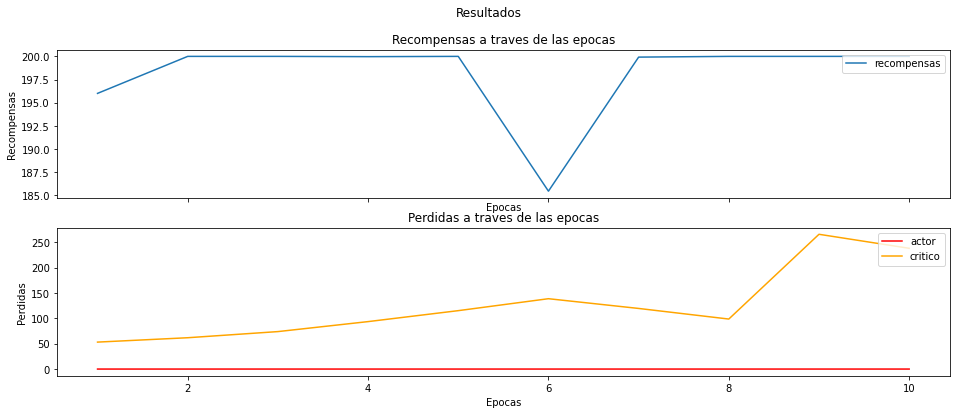

In [ ]:
import matplotlib.pyplot as plt

epocas = np.arange(1, epocas+1, 1)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.set_size_inches(16,6)
fig.suptitle('Resultados')

ax1.plot(epocas, recompensas, label="recompensas")
ax1.set_title("Recompensas a traves de las epocas")
ax1.legend(loc="upper right")
ax1.set(xlabel='Epocas', ylabel='Recompensas')

ax2.plot(epocas, politica_losses, c="red", label="actor")
ax2.plot(epocas, critico_losses, c="orange", label="critico")
ax2.set_title("Perdidas a traves de las epocas")
ax2.legend(loc="upper right")
ax2.set(xlabel='Epocas', ylabel='Perdidas')

plt.show()

### *2.6 Generamos un gif*
Generamos un gif que nos muestra qué tan bien aprendió nuestro agente.

1/1 [==============================] - 0s 20ms/step


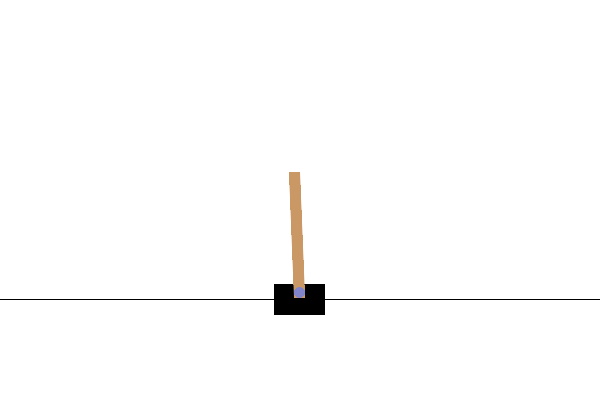

In [ ]:
juego = "CartPole-v0"
env = gym.make(juego, render_mode='rgb_array')

def generar_gif(env, agente, max_pasos):
    estado = env.reset()
    estado = tf.constant(estado, dtype=tf.float32)

    screen = env.render()
    screen = np.asarray(screen[0])

    images = [pil_image.fromarray(screen)]

    for i in range(1, max_pasos + 1):
        estado = tf.expand_dims(estado, 0)
        accion_proba, _ = agente.actor.predict(estado)[0]
        accion = np.argmax(np.squeeze(accion_proba))

        estado, reward, done, truncated = env.step(accion)
        estado = tf.constant(estado, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render()
            screen = np.asarray(screen[0])
            images.append(pil_image.fromarray(screen))

        if done:
            break

    return images

images = generar_gif(env, agente, nro_pasos)
image_file = 'cartpole-v0.gif'

images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=3)

mostrar_imagen(image_file)

## **3. Validación de Resultados**

En esta sección, observaremos todos los resultados obtenidos de entrenar un agente con el algoritmo PPO desarrollado con TensorFlow.

Al entrenar el agente con 200 épocas, pudimos obtener buenos resultados. Aquí podemos observar cómo a medida que pasan las épocas las recompensas obtenidas aumentan y las pérdidas obtenidas disminuyen.

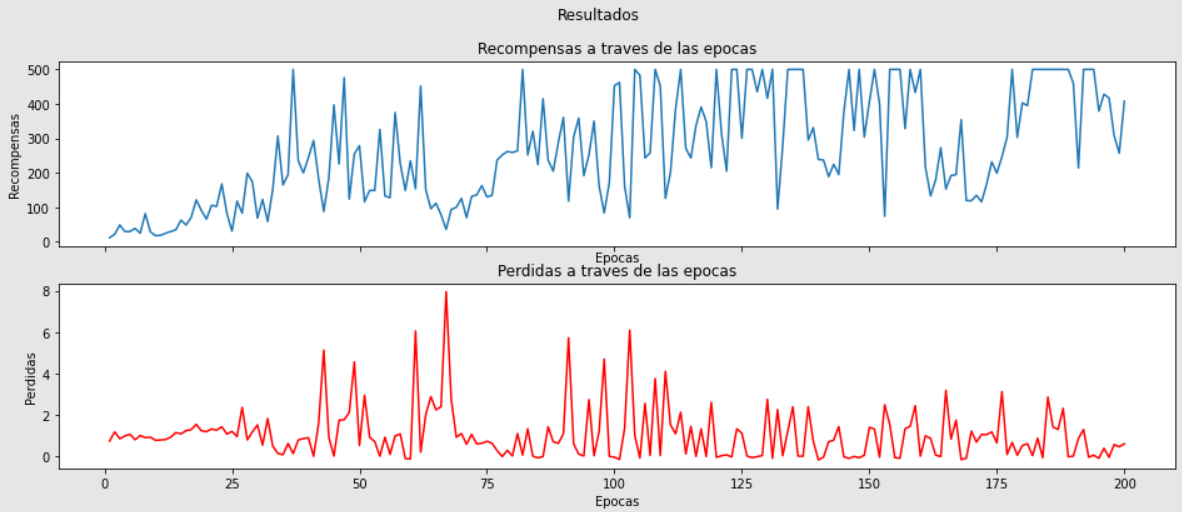

En los resultados obtenidos podemos ver cómo el agente mejora su rendimiento a partir de las épocas.

**Agente entrenado con 50 épocas**

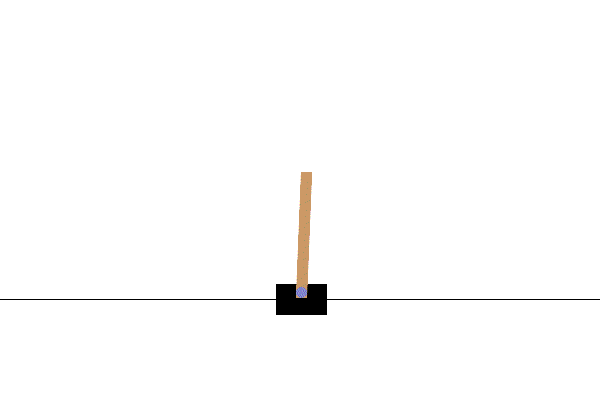

**Agente entrenado con 100 épocas**

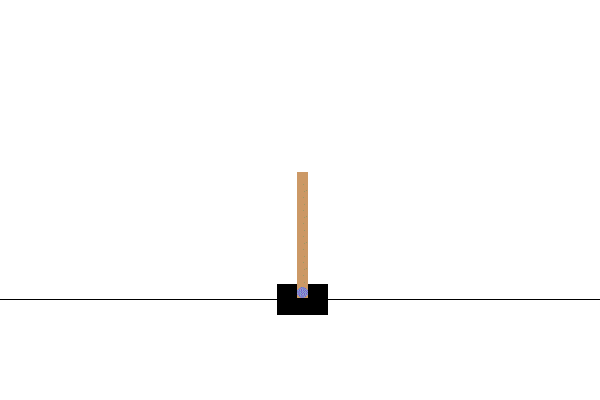

**Agente entrenado con 150 épocas**

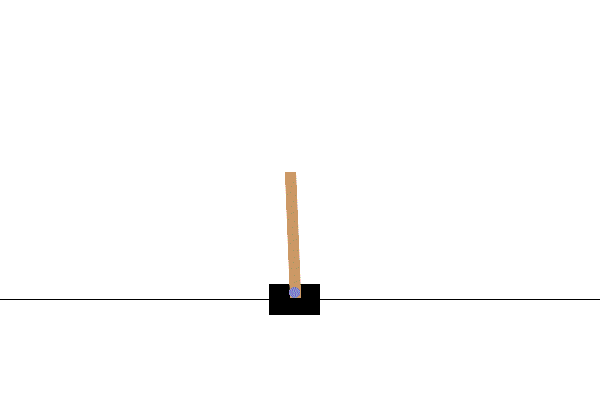

**Agente entrenado con 200 épocas**

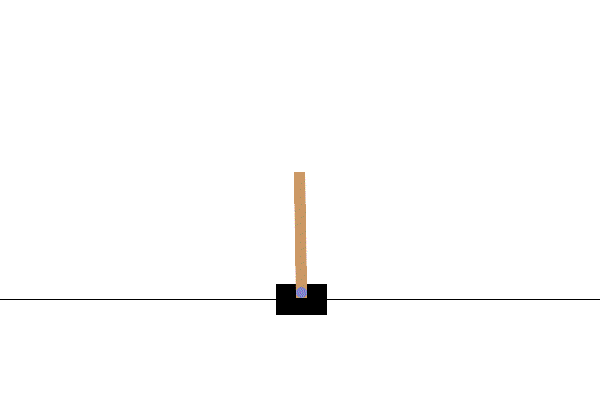